# Downloading Data and Libraries

In [1]:
!pip install -q yfinance
!pip install -q pandas pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error 
from scipy.optimize import minimize
from scipy.stats import norm
import math
import yfinance as yf
import pandas_datareader.data as web
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Collected - 17/7/24 21:34
S = 5588.27
imp_vol = 0.1263
hist_vol = 0.0819

K7 = [i for i in range(5540, 5635 + 1 , 5)]
c7 = [69.0, 65.35, 61.8, 58.2, 54.75, 51.45, 48.25, 45.2, 42.25, 39.35, 36.6, 34.0, 31.45, 29.05, 26.7, 24.55, 22.5, 20.5, 18.7, 17]
p7 = [15.75,17.05,18.5,20.0,21.6,23.3,25.1,27.0,29.0,31.15,33.4,35.8,38.2,40.75,43.5,46.35,49.25,52.25,55.45,58.75]

K30 = [5510,5520,5525,5530,5540,5550,5560,5570,5575,5580,5590,5600,5610,5620,5625,5630,5640,5650,5660,5670]
c30 = [140.75,133.35,129.6,126.35,119.15,112.30,105.50,98.80,95.60,92.55,86.25,80.45,74.75,69.25,66.65,64.05,59.05,54.35,49.85,45.65]
p30 = [40.75,43.40,44.7,46.0,48.8,51.8,54.95,58.3,60.05,61.85,65.65,69.65,73.95,78.4,80.75,83.1,88.1,93.25,98.75,104.5]

K95 = [i for i in range(5540, 5635 + 1, 5)]
c95 = [216.3,213.0,209.2,205.8,202.3,198.9,195.75,192.1,188.7,185.4,182.1,178.85,175.85,172.35,169.15,166.05,162.9,159.8,156.8,153.7]
p95 = [96.45,97.85,99.25,100.65,102.15,103.65,105.2,106.75,108.3,109.9,111.5,113.2,114.85,116.6,118.3,120.1,121.9,123.7,125.5,127.4]

In [4]:
# Collected 25/08/24 19:01
S = 5634.61
imp_vol = 0.1202
hist_vol = 0.1942

K7 = [i for i in range(5535, 5730 + 1, 5)]
c7  = [111.45, 107.25, 103.45, 98.85, 94.75, 90.75, 86.75, 82.85, 78.95, 75.15, 71.45, 67.65, 64.10, 60.65, 57.20, 53.90, 50.80, 47.70, 44.65, 41.75, 38.95, 36.25, 33.65, 31.15, 28.75, 26.45, 24.35, 22.25, 20.25, 18.45, 16.70, 15.05, 13.50, 12.10, 10.80, 9.55, 8.40, 7.40, 6.50, 5.65]

K30 = [5475.00, 5480.00, 5490.00, 5500.00, 5510.00, 5520.00, 5525.00, 5530.00, 5540.00, 5550.00, 5560.00, 5570.00, 5575.00, 5580.00, 5590.00, 5600.00, 5610.00, 5620.00, 5625.00, 5630.00, 5640.00, 5650.00, 5660.00, 5670.00, 5675.00, 5680.00, 5690.00, 5700.00, 5725.00, 5750.00, 5775.00, 5800.00, 5850.00, 5900.00, 6000.00, 6100.00, 6200.00, 6300.00, 6400.00]
c30 = [209.45, 205.70, 196.85, 188.55, 180.35, 172.25, 168.25, 164.25, 156.10, 148.35, 140.75, 133.25, 129.55, 125.85, 118.70, 111.65, 104.85, 98.15, 94.95, 91.75, 85.40, 79.45, 73.65, 68.05, 65.40, 62.70, 57.75, 52.95, 42.10, 32.95, 25.40, 19.30, 10.75, 5.85, 2.00, 0.00, 0.60, 0.00, 0.00]

In [5]:
start = "1990-07-17"
end="2024-07-17"

data = yf.download("^GSPC",start=start, end=end, interval="1d")
data.index = pd.to_datetime(data.index, format = '%d/%m/%Y')
prices = data["Close"]
ratios = prices / prices.shift(1)
ratios.dropna(inplace=True)
log_returns = np.log(ratios).values
sigma_hat = np.std(log_returns) * np.sqrt(252)

df = web.DataReader('DFF', 'fred', "2024-07-15", "2024-07-17")
r = np.mean(df["DFF"])/100
print("Annualised Volatility:", sigma_hat)
print("Risk-Free Rate (1-Month Treasury):", r)

[*********************100%***********************]  1 of 1 completed


Annualised Volatility: 0.18167887753996848
Risk-Free Rate (1-Month Treasury): 0.0533


# Parameter Historical Estimation

We collect the historical estimates of our models parameters to set our boundary values for MLE later on.

In [6]:
mean_log_return = np.mean(log_returns)
std_log_return = np.std(log_returns)

threshold_up = mean_log_return + 5.5  * std_log_return
threshold_down = mean_log_return - 5.5 * std_log_return

jumps = log_returns[(log_returns > threshold_up) | (log_returns < threshold_down)]

jumps_up = log_returns[log_returns > threshold_up]
jumps_down = log_returns[log_returns < threshold_down]

jump_count = len(jumps_up) + len(jumps_down)

lambd_opt = jump_count / (len(log_returns)/252)  # Estimated jump intensity
p_opt = len(jumps_up) / jump_count  # Probability of upward jump
eta1_opt = 1/np.mean(jumps_up)  # Rate of upward jumps
eta2_opt = 1/-np.mean(jumps_down)  # Rate of downward jumps

k_opt = np.mean(jumps)  # Mean jump size
delta_opt = np.std(jumps)  # Standard deviation of jump size

# Initial Guess is historical estimates
initial_guess_merton = [lambd_opt, k_opt, delta_opt]
initial_guess_kou = [lambd_opt, p_opt, eta1_opt, eta2_opt]

print("Kou Params")
print("lambda:",lambd_opt, "p:", p_opt, "eta_1:", eta1_opt,"eta_2:", eta2_opt)
print(" ")
print("Merton Params")
print("k:", k_opt, "delta:",delta_opt)

Kou Params
lambda: 0.5885787691229709 p: 0.35 eta_1: 11.78891401450251 eta_2: 12.123285204962517
 
Merton Params
k: -0.02392692072480389 delta: 0.0816465366837397


# Defining Option Pricing Formulae

Defines functions that calculate the call option prices using the Black-Scholes, Merton Jump Diffusion and Kou Jump Diffusion Models.

In [7]:
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def merton_jump_diffusion_call(S, K, T, r, sigma, lambd, k, delta):
    call_price = 0.0
    for n in range(50):
        r_n = r - lambd * k + n * np.log(1 + k) / T
        sigma_n = np.sqrt(sigma ** 2 + (n * delta ** 2) / T)
        poisson_prob = np.exp(-lambd * T) * (lambd * T) ** n / math.factorial(n)
        call_price += poisson_prob * bs_call(S, K, T, r_n, sigma_n)
    return call_price

def kou_jump_diffusion_call(S, K, T, r, sigma, lamb, p, eta1, eta2):
    call_price = 0.0
    epsilon = 1e-100
    for n in range(50):
        if n == 0:
            r_n = r - lamb * (p / eta1 + (1 - p) / eta2)
            sigma_n = sigma
        else:
            r_n = r - lamb * (p / eta1 + (1 - p) / eta2) + (n / T) * np.log(1 + (p * eta1 + (1 - p) * eta2) / (n + epsilon))
            sigma_n = np.sqrt(sigma ** 2 + (n / T) * (p * eta1 ** 2 + (1 - p) * eta2 ** 2))
        
        poisson_log_prob = -lamb * T + n * np.log(lamb * T) - np.log(math.factorial(n) + epsilon)
        poisson_prob = np.exp(poisson_log_prob)
        
        bs_price = bs_call(S, K, T, r_n, sigma_n)
        call_price += poisson_prob * bs_price
        
        if poisson_prob < 1e-10:  # Convergence check
            break
    
    return call_price

# Parameter Calibration

This section calibrates the parameter values based on the true option prices. I implement bounds close to the parameters historical estimations (lower and upper bounds are 0.5x and 2x the historical estimates respectively). This prevents the parameter values from overfitting. The method of calibration is Maximum Liklihood Estimation where the metric to minimise is the mean squared error.

In [8]:
def objective_function_merton(params, S, K, T, r, market_prices, sigma):
    lambd, k, delta = params
    model_prices = [merton_jump_diffusion_call(S, K[i], T, r, sigma, lambd, k, delta) for i in range(len(K))]
    return np.sum((np.array(model_prices) - market_prices) ** 2)

def objective_function_kou(params, S, K, T, r, market_prices, sigma):
    lamb, p, eta1, eta2 = params
    model_prices = [kou_jump_diffusion_call(S, K[i], T, r, sigma, lamb, p, eta1, eta2) for i in range(len(K))]
    return np.sum((np.array(model_prices) - market_prices) ** 2)

def calibrate_merton_params(S, K, T, r, sigma, market_prices, initial_guess):
    bounds = [(initial_guess_merton[0]*0.5,initial_guess_merton[0]*2),
              (initial_guess_merton[1]*2,initial_guess_merton[1]*0.5),  # Reverse multipliers (0.5 and 2) as initial guess is negative
              (initial_guess_merton[2]*0.5,initial_guess_merton[2]*2)]
    result = minimize(objective_function_merton, initial_guess, args=(S, K, T, r, market_prices, sigma), method='L-BFGS-B', bounds=bounds)
    return result.x

def calibrate_kou_params(S, K, T, r, sigma, market_prices, initial_guess):
    bounds = [(initial_guess_kou[0]*0.5,initial_guess_kou[0]*2),
              (initial_guess_kou[1]*0.5,initial_guess_kou[1]*2),
              (initial_guess_kou[2]*0.5,initial_guess_kou[2]*2),
              (initial_guess_kou[3]*0.5,initial_guess_kou[3]*2)]
    result = minimize(objective_function_kou, initial_guess, args=(S, K, T, r, market_prices, sigma), method='L-BFGS-B', bounds=bounds)
    return result.x


# Calibrated Parameter Values
calibrated_merton_7 = calibrate_merton_params(S, K7, 7/365, r, sigma_hat, c7, initial_guess_merton)
calibrated_kou_7 = calibrate_kou_params(S, K7, 7/365, r, sigma_hat, c7, initial_guess_kou)

calibrated_merton_30 = calibrate_merton_params(S, K30, 30/365, r, sigma_hat, c30, initial_guess_merton)
calibrated_kou_30 = calibrate_kou_params(S, K30, 30/365, r, sigma_hat, c30, initial_guess_kou)

calibrated_merton_95 = calibrate_merton_params(S, K95, 95/365, r, sigma_hat, c95, initial_guess_merton)
calibrated_kou_95 = calibrate_kou_params(S, K95, 95/365, r, sigma_hat, c95, initial_guess_kou)

# Estimating Option Prices

We estiamte the prices of call options 7, 30 and 95 to maturity using the Black-Scholes, Merton Jump Diffusion and Kou Jump Diffusion models. We use parameter values calibrated from real market data.

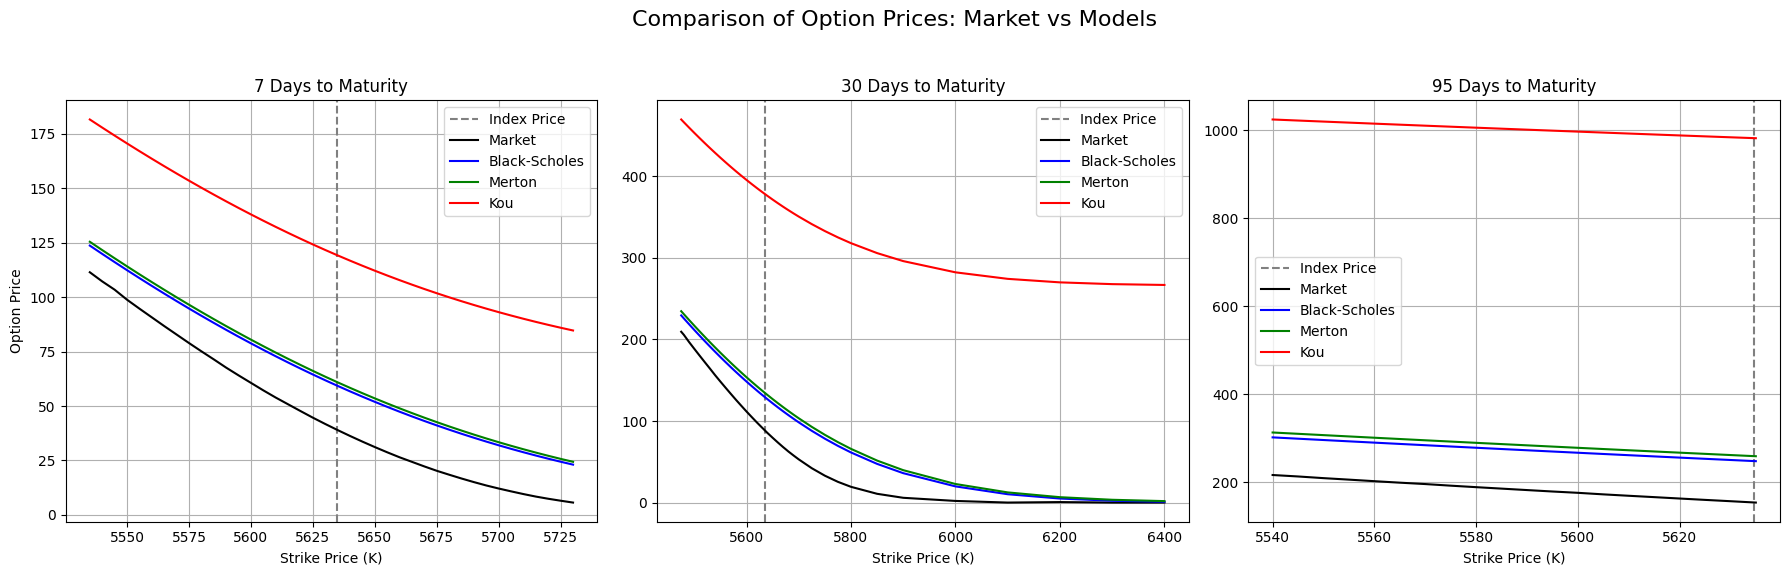

Mean Squared Errors for 7 Days:
Black-Scholes: 338.03149074811773
Merton: 398.2529551672077
Kou: 6104.771166564767

Mean Squared Errors for 30 Days:
Black-Scholes: 1159.8417965990025
Merton: 1498.7161050972118
Kou: 79697.44368613721

Mean Squared Errors for 95 Days:
Black-Scholes: 8106.513121479805
Merton: 10246.13750374549
Kou: 669140.5623194498


In [9]:
# Calculate prices for 7 days to maturity
bs_prices_7 = [bs_call(S, k, 7/365, r, sigma_hat) for k in K7]
merton_prices_7 = [merton_jump_diffusion_call(S, k, 7/365, r, sigma_hat, *initial_guess_merton) for k in K7]
kou_prices_7 = [kou_jump_diffusion_call(S, k, 7/365, r, sigma_hat, *initial_guess_kou) for k in K7]

# Calculate prices for 30 days to maturity
bs_prices_30 = [bs_call(S, k, 30/365, r, sigma_hat) for k in K30]
merton_prices_30 = [merton_jump_diffusion_call(S, k, 30/365, r, sigma_hat, *initial_guess_merton) for k in K30]
kou_prices_30 = [kou_jump_diffusion_call(S, k, 30/365, r, sigma_hat, *initial_guess_kou) for k in K30]

# Calculate prices for 95 days to maturity
bs_prices_95 = [bs_call(S, k, 95/365, r, sigma_hat) for k in K95]
merton_prices_95 = [merton_jump_diffusion_call(S, k, 95/365, r, sigma_hat, *initial_guess_merton) for k in K95]
kou_prices_95 = [kou_jump_diffusion_call(S, k, 95/365, r, sigma_hat, *initial_guess_kou) for k in K95]


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for 7 days to maturity
axs[0].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[0].plot(K7, c7, label="Market", color='black')
axs[0].plot(K7, bs_prices_7, label="Black-Scholes", color='blue')
axs[0].plot(K7, merton_prices_7, label="Merton", color='green')
axs[0].plot(K7, kou_prices_7, label="Kou", color='red')
axs[0].set_title("7 Days to Maturity")
axs[0].set_xlabel("Strike Price (K)")
axs[0].set_ylabel("Option Price")
axs[0].legend()
axs[0].grid(True)

# Plot for 30 days to maturity
axs[1].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[1].plot(K30, c30, label="Market", color='black')
axs[1].plot(K30, bs_prices_30, label="Black-Scholes", color='blue')
axs[1].plot(K30, merton_prices_30, label="Merton", color='green')
axs[1].plot(K30, kou_prices_30, label="Kou", color='red')
axs[1].set_title("30 Days to Maturity")
axs[1].set_xlabel("Strike Price (K)")
axs[1].legend()
axs[1].grid(True)

# Plot for 95 days to maturity
axs[2].axvline(x=S, color='grey', linestyle='--', label="Index Price")
axs[2].plot(K95, c95, label="Market", color='black')
axs[2].plot(K95, bs_prices_95, label="Black-Scholes", color='blue')
axs[2].plot(K95, merton_prices_95, label="Merton", color='green')
axs[2].plot(K95, kou_prices_95, label="Kou", color='red')
axs[2].set_title("95 Days to Maturity")
axs[2].set_xlabel("Strike Price (K)")
axs[2].legend()
axs[2].grid(True)

fig.suptitle("Comparison of Option Prices: Market vs Models", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculating and Printing MSEs for each maturity
print("Mean Squared Errors for 7 Days:")
print(f"Black-Scholes: {mean_squared_error(c7, bs_prices_7)}")
print(f"Merton: {mean_squared_error(c7, merton_prices_7)}")
print(f"Kou: {mean_squared_error(c7, kou_prices_7)}")

print("\nMean Squared Errors for 30 Days:")
print(f"Black-Scholes: {mean_squared_error(c30, bs_prices_30)}")
print(f"Merton: {mean_squared_error(c30, merton_prices_30)}")
print(f"Kou: {mean_squared_error(c30, kou_prices_30)}")

print("\nMean Squared Errors for 95 Days:")
print(f"Black-Scholes: {mean_squared_error(c95, bs_prices_95)}")
print(f"Merton: {mean_squared_error(c95, merton_prices_95)}")
print(f"Kou: {mean_squared_error(c95, kou_prices_95)}")


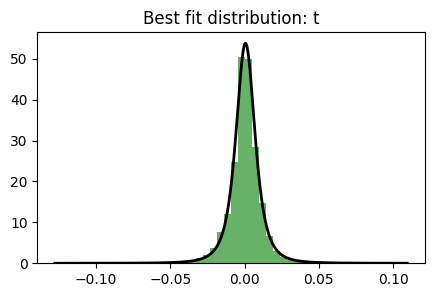

Best fitting distribution for flat: t
t parameters for flat: (2.7710464538990656, 0.0006443549473430204, 0.006790434500093159)


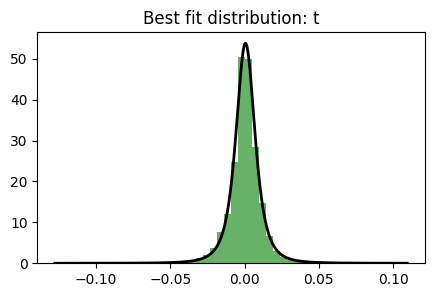

Best fitting distribution for bull: t
t parameters for bull: (2.7710464538990656, 0.0006443549473430204, 0.006790434500093159)


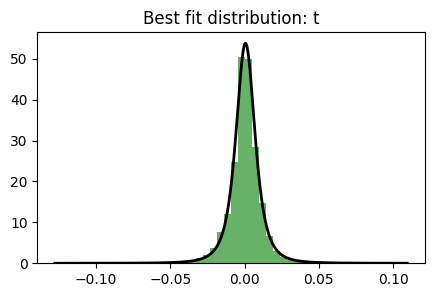

Best fitting distribution for bear: t
t parameters for bear: (2.7710464538990656, 0.0006443549473430204, 0.006790434500093159)


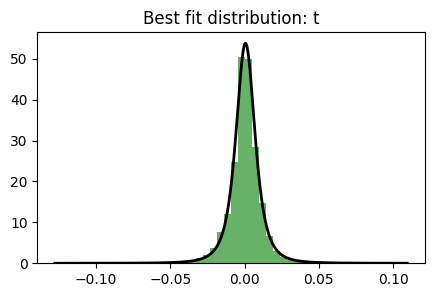

Best fitting distribution for test: t
t parameters for test: (2.7710464538990656, 0.0006443549473430204, 0.006790434500093159)


In [10]:
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize
from scipy.stats import norm

# Assuming 'data' is your DataFrame with a DatetimeIndex

log_returns = np.log(ratios)

market_conditions = {
    'flat': log_returns.loc['2018-01-01 00:00:00':'2021-01-01 00:00:00'],
    'bull': log_returns.loc['2021-01-01 00:00:00':'2022-01-01 00:00:00'],
    'bear': log_returns.loc['2022-01-01 00:00:00':'2023-01-01 00:00:00'],
    'test': log_returns.loc['2023-01-01 00:00:00':]
}
log_returns = np.log(ratios).values

def kou_pdf(x, mu, sigma, lamb, p, eta1, eta2, delta_t=1):
    no_jump_pdf = (1 - lamb * delta_t) * norm.pdf(x, mu * delta_t, sigma * np.sqrt(delta_t))
    upward_jump_pdf = (lamb * delta_t * p * eta1 * np.exp((sigma**2 * eta1**2 * delta_t) / 2) *
                       np.exp(-eta1 * (x - mu * delta_t)) *
                       norm.cdf((x - mu * delta_t - sigma**2 * eta1 * delta_t) / (sigma * np.sqrt(delta_t))))
    downward_jump_pdf = (lamb * delta_t * (1 - p) * eta2 * np.exp((sigma**2 * eta2**2 * delta_t) / 2) *
                         np.exp(eta2 * (x - mu * delta_t)) *
                         norm.cdf((-x + mu * delta_t + sigma**2 * eta2 * delta_t) / (sigma * np.sqrt(delta_t))))
    return no_jump_pdf + upward_jump_pdf + downward_jump_pdf

def kou_cdf(x, mu, sigma, lamb, p, eta1, eta2, delta_t=1):
    cdf_values = np.array([np.sum(kou_pdf(xi, mu, sigma, lamb, p, eta1, eta2, delta_t) * delta_t) for xi in x])
    return cdf_values

def kou_log_likelihood(params, data):
    mu, sigma, lamb, p, eta1, eta2, delta_t = params
    pdf_values = kou_pdf(data, mu, sigma, lamb, p, eta1, eta2, delta_t)
    return -np.sum(np.log(pdf_values + 1e-9))  # Add small constant to avoid log(0)

def fit_kou_model(log_returns):
    mu, sigma = np.mean(log_returns), np.std(log_returns)
    threshold = 3 * sigma
    jump_indices = np.where(np.abs(log_returns - mu) > threshold)[0]
    lamb = len(jump_indices) / len(log_returns)
    jump_sizes = log_returns[jump_indices] - mu

    positive_jumps = jump_sizes[jump_sizes > 0]
    negative_jumps = -jump_sizes[jump_sizes < 0]
    eta1 = 1 / np.mean(positive_jumps) if len(positive_jumps) > 0 else 1.0
    eta2 = 1 / np.mean(negative_jumps) if len(negative_jumps) > 0 else 1.0
    p = len(positive_jumps) / len(jump_sizes) if len(jump_sizes) > 0 else 0.5

    initial_params = [mu, sigma, lamb, p, eta1, eta2, 1]
    return minimize(kou_log_likelihood, initial_params, args=(log_returns,), method='Nelder-Mead').x

def fit_distributions(log_returns):
    distributions = {"normal": stats.norm, "t": stats.t, "gpd": stats.genpareto}
    return {name: (dist, dist.fit(log_returns)) for name, dist in distributions.items()}

def goodness_of_fit(data, distribution, params):
    cdf = lambda x: distribution.cdf(x, *params)
    return stats.kstest(data, cdf)

def evaluate_best_fit(log_returns, fitted_params, kou_params):
    gof_results = {name: goodness_of_fit(log_returns, dist, params) for name, (dist, params) in fitted_params.items()}
    gof_results["kou"] = stats.kstest(log_returns, lambda x: kou_cdf(x, *kou_params))
    return min(gof_results, key=lambda k: gof_results[k][0]), gof_results

def plot_best_fit(log_returns, best_fit, best_params, fitted_params, kou_params):
    x = np.linspace(min(log_returns), max(log_returns), 1000)
    if best_fit == "kou":
        pdf = kou_pdf(x, *kou_params)
    else:
        pdf = fitted_params[best_fit][0].pdf(x, *best_params)
    
    plt.figure(figsize=(5, 3))
    plt.hist(log_returns, bins=50, density=True, alpha=0.6, color='g')
    plt.plot(x, pdf, 'k', linewidth=2)
    plt.title(f"Best fit distribution: {best_fit}")
    plt.show()

for condition, prices in market_conditions.items():
    kou_params = fit_kou_model(log_returns)
    fitted_params = fit_distributions(log_returns)
    best_fit, gof_results = evaluate_best_fit(log_returns, fitted_params, kou_params)
    best_params = kou_params if best_fit == "kou" else fitted_params[best_fit][1]
    plot_best_fit(log_returns, best_fit, best_params, fitted_params, kou_params)
    print(f"Best fitting distribution for {condition}: {best_fit}")
    if best_fit == "kou":
        print(f"Kou model parameters for {condition}: {kou_params}")
    else:
        print(f"{best_fit} parameters for {condition}: {best_params}")